

# Simulating impact of peer review on supporting meritorious science


findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


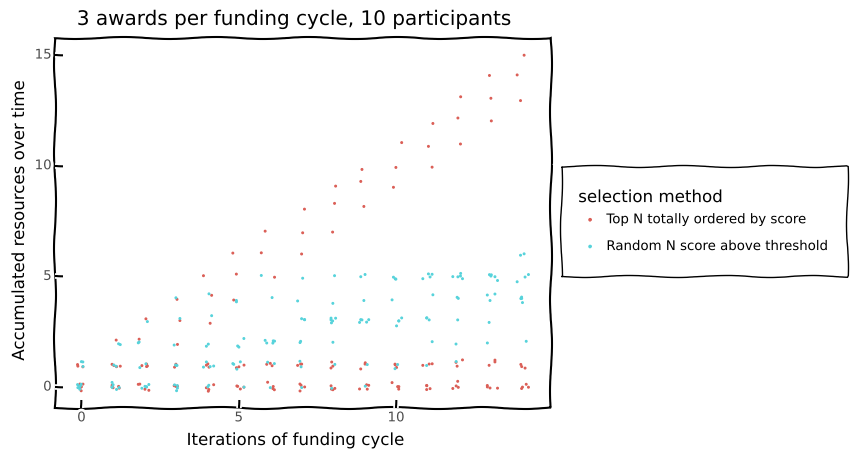

In [10]:
from numpy.random import default_rng
import random
import pandas as pd
import plotnine

rng = default_rng()

nScientists = 10

sci = [{}] * nScientists
sci2 = [{}] * nScientists

for i in range(nScientists):
    sci[i] = {'id': i, 'reputation': .1, 'merit': .1, 'resources': 0}
    if i%10 == 0:
        sci[i]['merit'] += 0
    sci2[i] = {'id': i, 'reputation': .1, 'merit': .1, 'resources': 0}
    if i%10 == 0:
        sci2[i]['merit'] += 0
        
start = 0
nApplicants = nScientists
nRfp = 15
nFunded = 3
threshold = 0.2
sd_merit = 0.1
x = []
y = []
y2 = []

for rfp in range(0, nRfp):
    for i in range(0, nApplicants):
        sci[i]['score'] = rng.normal(sci[i]['merit'], sd_merit, 1)[0] +\
                                 sci[i]['reputation']
        sci2[i]['score'] = rng.normal(sci2[i]['merit'], sd_merit, 1)[0] +\
                                  sci2[i]['reputation']
    sorted_scores = sorted(sci, key=lambda s: s['score'], reverse=True)
    for winner in sorted_scores[0:nFunded]:
        winner['reputation'] += .1
        winner['resources'] += 1

    candidates = [s for s in sci2 if s['score'] > threshold]
    for winner in random.sample(candidates, nFunded):
        winner['reputation'] += .1
        winner['resources'] += 1

    jitter = .1
    for i in range(0, nScientists):
        x.append(rng.normal(rfp, jitter, 1)[0])
        y.append(rng.normal(sci[i]['resources'], jitter, 1)[0])
        y2.append(rng.normal(sci2[i]['resources'], jitter, 1)[0])

df = pd.DataFrame()
df2 = pd.DataFrame()
df['resources'] = y
df2['resources'] = y2
df['rfp_count'] = x
df2['rfp_count'] = x
df['selection method'] = ['Top N totally ordered by score'] * len(x)
df2['selection method'] = ['Random N score above threshold'] * len(x)


plot = (
    plotnine.ggplot(mapping=plotnine.aes(x='rfp_count', y='resources', group = 'selection method'))
    + plotnine.geom_point(data=df, mapping=plotnine.aes(color='selection method'), size=.2) 
    + plotnine.geom_point(data=df2, mapping=plotnine.aes(color='selection method'), size=.2)
    + plotnine.ggtitle(f"{nFunded} awards per funding cycle, {nApplicants} participants")
    + plotnine.labs(x="Iterations of funding cycle", y="Accumulated resources over time")
    + plotnine.theme_xkcd()
    )

print(plot)
            
#print(sci)



